Original code:

In [ ]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Find the min and max values for each column
def dataset_minmax(dataset):
	minmax = list()
	for i in range(len(dataset[0])):
		col_values = [row[i] for row in dataset]
		value_min = min(col_values)
		value_max = max(col_values)
		minmax.append([value_min, value_max])
	return minmax

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for _ in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (row1[i] - row2[i])**2
	return sqrt(distance)

# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
	distances = list()
	for train_row in train:
		dist = euclidean_distance(test_row, train_row)
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

# Make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

# kNN Algorithm
def k_nearest_neighbors(train, test, num_neighbors):
	predictions = list()
	for row in test:
		output = predict_classification(train, row, num_neighbors)
		predictions.append(output)
	return(predictions)
# Test the kNN on the Iris Flowers dataset
seed(1)
filename = 'iris_data.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
# evaluate algorithm
n_folds = 5
num_neighbors = 5
scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [96.66666666666667, 96.66666666666667, 100.0, 90.0, 100.0]
Mean Accuracy: 96.667%


# **Reviewing the dataset**

Let's review our dataset first to understand our dataset. 

In [ ]:
dataset = load_csv(filename)

print('number of data: ', len(dataset))

for i in range(len(dataset[0])):
    print('value of feature #', i+1, '=', dataset[0][i])
    

number of data:  150
value of feature # 1 = 5.1
value of feature # 2 = 3.5
value of feature # 3 = 1.4
value of feature # 4 = 0.2
value of feature # 5 = Iris-setosa


So, our dataset consists of 150 data containing 5 features. 4 features are continuous numerical and 1 feature is nominal categorical. Because there is a nominal categorical value, we need to encode those values.

In [ ]:
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

{'Iris-versicolor': 0, 'Iris-virginica': 1, 'Iris-setosa': 2}

# **1. Choosing the K value**

Although there are no exact answer on how to decide the K, it is suggested set the number of k to be around $\sqrt{n}$, where n is the number of data in our training data. So, in our case, the optimal value of K should lie between $\sqrt{120}$, which is around 11. So, let's check if that is true by iterating the k value from 1 to 120:

maximum accuracy:  98.00000000000001 %% with K value:  10


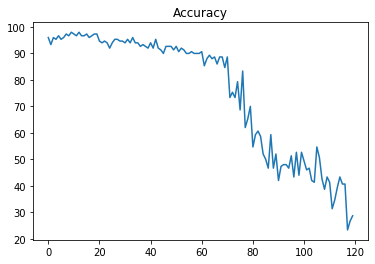

In [ ]:
performance = list()
for i in range (1,121):
    num_neighbors = i
    scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors)
    mean_score = (sum(scores)/float(len(scores)))
    #print('K: ', i,' Mean Accuracy: %.3f%%'  %mean_score)
    performance.append(mean_score)
    

from matplotlib import pyplot as plt

print('maximum accuracy: ', max(performance), '%% with K value: ', performance.index(max(performance))+1)


plt.title('Accuracy')
plt.plot(performance)

So, based on the result above, the optimal value of K lies between 9-11, which accuracy is slightly better than the previous one if the value of K is 5. However, larger K doesn't always mean better since at some point it will overfit to the training data.

# **2. Regression using multivariate linear regression**

Since regression can't be used for classifying, we can't use the original target (iris-setosa,virginica,versicolor) to apply regression. Instead, we will use the fourth feature (fourth column) which is continuous numerical as the target value. In this case, we will use multivariate linear regression with gradient descent.


Our multiple linear legression can be written as: <br>
### $ y = \beta_0  + \beta_1x_{1} + \beta_2x_{2} + \beta_3x_{3}$ <br><br>
y is the predicted value, beta is the weight of corresponding feature, x is the value of the feature. 

note : x0 will be created with all 1 value to be multiplied by beta0

First, let's preapare our dataset:


In [ ]:
import pandas as pd

dataset = pd.DataFrame(load_csv(filename))
dataset.columns=['X1','X2','X3','Y',' ']

X= dataset.iloc[:, :3].astype('float')
new_col = [1.0]*len(X)
X.insert(loc=0, column = 'X0' ,value=new_col)

Y = dataset.iloc[:,3].astype('float')

beta = pd.DataFrame([0.0]*len(X.columns))

print(X.join(Y))
print(beta)

      X0   X1   X2   X3    Y
0    1.0  5.1  3.5  1.4  0.2
1    1.0  4.9  3.0  1.4  0.2
2    1.0  4.7  3.2  1.3  0.2
3    1.0  4.6  3.1  1.5  0.2
4    1.0  5.0  3.6  1.4  0.2
..   ...  ...  ...  ...  ...
145  1.0  6.7  3.0  5.2  2.3
146  1.0  6.3  2.5  5.0  1.9
147  1.0  6.5  3.0  5.2  2.0
148  1.0  6.2  3.4  5.4  2.3
149  1.0  5.9  3.0  5.1  1.8

[150 rows x 5 columns]
     0
0  0.0
1  0.0
2  0.0
3  0.0


Now that the data is ready, we can implement the gradient descent! Here, we are using SGD, which means the beta values will be updated each row evaluated. For this example, we will use 0.0001 learning rate and 100 epoches. Beta will be updated based on this formula:

$Loss = (y_{predicted} - y_{actual})^2$

$\frac{\partial Loss}{\partial \beta_i} = 2(y_{predicted}-y_{actual})x_i$

$\beta_i \leftarrow \beta_i - \eta \frac{\partial Loss}{\partial \beta_i}$

$\beta_i \leftarrow \beta_i - \eta (2 (y_{predicted}-y_{actual})x_i)$

where $\eta$ is the learning rate (0.0001)

So, the beta values after training are:
 [[-0.03132166]
 [-0.00559379]
 [-0.08590342]
 [ 0.41456748]]
And the RMSE is 0.04726747633199269


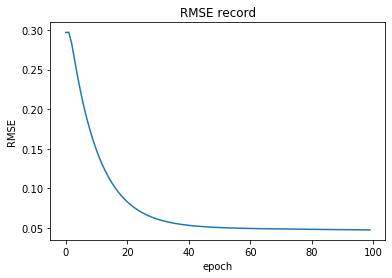

In [ ]:
epochs = 100
learning_rate = 0.0001

size = int(len(Y))

X = X.values
Y = Y.values
beta = beta.values

from sklearn.metrics import mean_squared_error

rmse_record = []
for iter in range(epochs):
    for row in range(size):
        Y_pred = 0.0
        for column in range(4):
            Y_pred += float(beta[column]* X[row][column])
        
        D_beta = [0.0]*4
        for column in range(4):
            D_beta[column] = float((2) * (Y_pred- Y[row]) * X[row][column])
            beta[column] = beta[column] - learning_rate * D_beta[column]
        
    Y_pred = []
    
    for row in range(size):
        temp_prediction = 0.0
        for column in range(4):
            temp_prediction += float(beta[column]* X[row][column] )
        
        Y_pred.append(temp_prediction)
    
    rmse_record.append(mean_squared_error(Y_pred,Y)) 

        
print('So, the beta values after training are:\n',beta)
print('And the RMSE is ' + str(rmse_record[iter]))
        
import matplotlib.pyplot as plt
plt.title('RMSE record')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.plot(rmse_record)

So, our multiple linear legression can be written as: <br>
### $ y = -0.03132166 + -0.00559379x_{1} + -0.08590342x_{2} + 0.41456748x_{3}$ <br><br>

notice that the third feature has the highest beta value, which means the feature 3 is more strongly related with our target value!

# **2. Regression using KNN**

Since regression can't be used for classifying, we can't use the original target (iris-setosa,virginica,versicolor) to apply regression. Instead, we will use the fourth feature (fourth column) which is continuous numerical as the target value. Actually regression in KNN is straightforward, we just need to calculate the average value of the K nearest neighbor. 

For example, our K is 5 and we want to predict the value of x, and the nearest neighbors of our test data is A, B, C, D, E. A value of x is 5, B is 4, C is 3, D is 3.5, and E is 1. The predicted value of our test data is:

<br>
$predicted = \frac{5 + 4+3+3.5+1}{5}$ <br>
$predicted = \frac{16.5}{5}$ <br>
$predicted = 3.3$ <br>



In [ ]:
# Make a prediction with neighbors
def predict_value(train, test_row, num_neighbors):
	neighbors = get_neighbors(train, test_row, num_neighbors)
	output_values = [row[-1] for row in neighbors]
	prediction = sum(output_values)/len(output_values)
	return prediction

def k_nearest_neighbors_regression(train, test, num_neighbors):
	predictions = list()
	for row in test:
		output = predict_value(train, row, num_neighbors)
		predictions.append(output)
	return(predictions)
from sklearn.metrics import mean_squared_error

def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	errors = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		RMSE = mean_squared_error(actual, predicted)
		errors.append(RMSE)
	return errors
	
    
dataset = load_csv(filename)

#deleting the 5th column
import numpy as np
dataset = np.delete(dataset,4, axis =1).astype(float).tolist()

num_neighbors = 5
list_RMSE = evaluate_algorithm(dataset, k_nearest_neighbors_regression, n_folds, num_neighbors)

print('RMSEs: %s' % list_RMSE)
print('Average RMSE: ' , (sum(list_RMSE)/float(len(list_RMSE))))

RMSEs: [0.028426666666666673, 0.03556, 0.03692000000000002, 0.03966666666666666, 0.02764]
Average RMSE:  0.03364266666666667


Just like the previous one, we will try to find the optimal value of K:

minimum error:  0.03373935185185184 with K value:  12


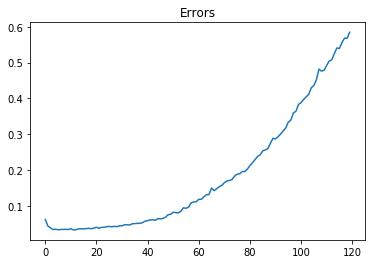

In [ ]:
dataset = load_csv(filename)

#deleting the 5th column
import numpy as np
dataset = np.delete(dataset,4, axis =1).astype(float).tolist()

list_errors = list()
for i in range (1,121):
    num_neighbors = i
    list_RMSE = evaluate_algorithm(dataset, k_nearest_neighbors_regression, n_folds, num_neighbors)
    mean_errors = (sum(list_RMSE)/float(len(list_RMSE)))
    #print('K: ', i,' Mean Errors: %.3f' %mean_errors)
    list_errors.append(mean_errors)
    

from matplotlib import pyplot as plt

print('minimum error: ', min(list_errors), 'with K value: ', list_errors.index(min(list_errors))+1)

plt.title('Errors')
plt.plot(list_errors)

And just like the classification model, the optimal value of K for our regression model is also around 11! The error is about 0.05, which is pretty good.

# **3. Testing Different Distance Metrics**

We will try hamming, manhattan and minkowski distance metrics. Before that, we need to redefine some function so that it can use different distance metrics. We are taking advantage of the args variable to pass the distance variable

In [ ]:
## Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors, distance):
	distances = list()
	for train_row in train:
		dist = distance(test_row, train_row) #distance is now flexible
		distances.append((train_row, dist))
	distances.sort(key=lambda tup: tup[1])
	neighbors = list()
	for i in range(num_neighbors):
		neighbors.append(distances[i][0])
	return neighbors

# Make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors, distance):
	neighbors = get_neighbors(train, test_row, num_neighbors, distance)
	output_values = [row[-1] for row in neighbors]
	prediction = max(set(output_values), key=output_values.count)
	return prediction

# kNN Algorithm
def k_nearest_neighbors(train, test, num_neighbors, distance):
	predictions = list()
	for row in test:
		output = predict_classification(train, row, num_neighbors, distance)
		predictions.append(output)
	return(predictions)

## **a. Hamming Distance**

hamming distance is calculated using this formula:

### $hamming(X,Y)= {\sum_{i=1}^{n} x_i != y_i }  $,

*note: "!=" return 1 if the left and right operand are different, return 0 otherwise.

Because hamming distance is only applicable on categorical data and all of our features are numeric, we need to discretize our dataset. Discretizaion aims to convert continuous numerical data type into categorical data type. The discretization method that we will use is binning, with 15 number of bins for each feature.

In [ ]:
def create_bins(lower_bound, upper_bound, quantity):
    
    delta = (upper_bound-lower_bound)/(quantity)
    
    temp = lower_bound
    bins = []
    for i in range(quantity+1):
        bins.append(temp)
        temp+= delta
    return bins

def discretize( df, num_bins):
    i = 0
    for (columnName, columnData) in df.iteritems():
        if(columnName == 4):
            break
        minimum = min(columnData.values)
        maximum = max(columnData.values)
        print('Colunm Name : ', columnName)
        print('Minimum Value: ', minimum)
        print('Maximum Value: ', maximum)
        bins = create_bins(float(minimum),float(maximum),int(num_bins))
        print('Bins for column ' + str(columnName) + ':')

        print(bins)
        print('previous values: ', columnData.values)

        columnData =pd.cut(x = columnData.astype(float),
                            bins = bins, 
                            labels = [i for i in range(1,num_bins+1)] )

        print('new values after binning: ', columnData.values,'\n\n')
        df.iloc[:,i]= columnData.values
        i +=1
    return df

import pandas as pd
df = pd.DataFrame(load_csv(filename))

df = discretize(df,15)

print(df)

Colunm Name :  0
Minimum Value:  4.3
Maximum Value:  7.9
Bins for column 0:
[4.3, 4.54, 4.78, 5.0200000000000005, 5.260000000000001, 5.500000000000001, 5.740000000000001, 5.980000000000001, 6.2200000000000015, 6.460000000000002, 6.700000000000002, 6.940000000000002, 7.180000000000002, 7.420000000000003, 7.660000000000003, 7.900000000000003]
previous values:  ['5.1' '4.9' '4.7' '4.6' '5.0' '5.4' '4.6' '5.0' '4.4' '4.9' '5.4' '4.8'
 '4.8' '4.3' '5.8' '5.7' '5.4' '5.1' '5.7' '5.1' '5.4' '5.1' '4.6' '5.1'
 '4.8' '5.0' '5.0' '5.2' '5.2' '4.7' '4.8' '5.4' '5.2' '5.5' '4.9' '5.0'
 '5.5' '4.9' '4.4' '5.1' '5.0' '4.5' '4.4' '5.0' '5.1' '4.8' '5.1' '4.6'
 '5.3' '5.0' '7.0' '6.4' '6.9' '5.5' '6.5' '5.7' '6.3' '4.9' '6.6' '5.2'
 '5.0' '5.9' '6.0' '6.1' '5.6' '6.7' '5.6' '5.8' '6.2' '5.6' '5.9' '6.1'
 '6.3' '6.1' '6.4' '6.6' '6.8' '6.7' '6.0' '5.7' '5.5' '5.5' '5.8' '6.0'
 '5.4' '6.0' '6.7' '6.3' '5.6' '5.5' '5.5' '6.1' '5.8' '5.0' '5.6' '5.7'
 '5.7' '6.2' '5.1' '5.7' '6.3' '5.8' '7.1' '6.3' '6.5' 

After the discretization, we can finally use the hamming distance!

maximum accuracy:  94.0 %% with K value:  10


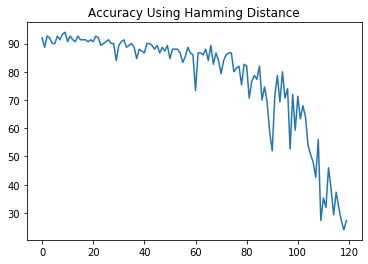

In [ ]:
def hamming_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		if( row1[i] != row2[i]):
			distance += 1
	return distance

dataset = df.values.tolist()


performance = list()
for i in range (1,121):
    num_neighbors = i
    scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors, hamming_distance)
    mean_score = (sum(scores)/float(len(scores)))
    #print('K: ', i,' Mean Accuracy: %.3f%%'  %mean_score)
    performance.append(mean_score)
    

from matplotlib import pyplot as plt

print('maximum accuracy: ', max(performance), '%% with K value: ', performance.index(max(performance)) +1 )


plt.title('Accuracy Using Hamming Distance')
plt.plot(performance)


The result is slightly worse than the euclidean distance! Perhaps our features are not suitable for hamming distance!

## **b. Manhattan Distance**

formula of manhattan distance:

### $manhattan(X,Y)= {\sum_{i=1}^{n} {|x_i -y_i|}}  $

maximum accuracy:  98.00000000000001 %% with K value:  17


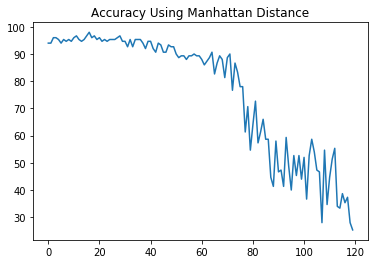

In [ ]:
def manhattan_distance(row1, row2):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += abs( float(row1[i]) - float(row2[i]) )
	return distance

dataset = load_csv(filename)

performance = list()
for i in range (1,121):
    num_neighbors = i
    scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors, manhattan_distance)
    mean_score = (sum(scores)/float(len(scores)))
    #print('K: ', i,' Mean Accuracy: %.3f%%'  %mean_score)
    performance.append(mean_score)
    

from matplotlib import pyplot as plt

print('maximum accuracy: ', max(performance), '%% with K value: ', performance.index(max(performance))+1)


plt.title('Accuracy Using Manhattan Distance')
plt.plot(performance)

The result is similar to euclidean distance!

## **c. Minkowski Distance (with p = 0.5)**

formula of minkowski distance:
### $minkowski(X,Y)= {(\sum_{i=1}^{n} {|x_i -y_i|}^{p})}^{\frac{1}{p}}  $

In this case, we will use p = 0.5

maximum accuracy:  96.66666666666667 %% with K value:  17


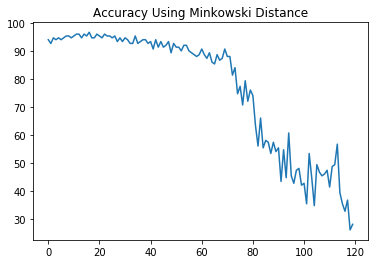

In [ ]:
def minkowski_distance(row1, row2, p=0.5):
	distance = 0.0
	for i in range(len(row1)-1):
		distance += (abs(float(row1[i]) - float(row2[i])))**p
	return distance**(1.0)

dataset = load_csv(filename)

performance = list()
for i in range (1,121):
    num_neighbors = i
    scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors, minkowski_distance)
    mean_score = (sum(scores)/float(len(scores)))
    #print('K: ', i,' Mean Accuracy: %.3f%%'  %mean_score)
    performance.append(mean_score)
    

from matplotlib import pyplot as plt

print('maximum accuracy: ', max(performance), '%% with K value: ', performance.index(max(performance))+ 1)


plt.title('Accuracy Using Minkowski Distance')
plt.plot(performance)

The result is also similar to euclidean distance!

# **4. Data Preparation**

## **a. Minmax Scaling Normalization**

In [ ]:
dataset = load_csv(filename)

for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

print('Before normalization (minmax scaling):\n\n',dataset[:10])

minmax = dataset_minmax(dataset)
normalize_dataset(dataset,minmax)

print('After normalization (minmax scaling):\n\n',dataset[:10])

Before normalization (minmax scaling):

 [[5.1, 3.5, 1.4, 0.2, 2], [4.9, 3.0, 1.4, 0.2, 2], [4.7, 3.2, 1.3, 0.2, 2], [4.6, 3.1, 1.5, 0.2, 2], [5.0, 3.6, 1.4, 0.2, 2], [5.4, 3.9, 1.7, 0.4, 2], [4.6, 3.4, 1.4, 0.3, 2], [5.0, 3.4, 1.5, 0.2, 2], [4.4, 2.9, 1.4, 0.2, 2], [4.9, 3.1, 1.5, 0.1, 2]]
After normalization (minmax scaling):

 [[0.22222222222222213, 0.6249999999999999, 0.06779661016949151, 0.04166666666666667, 1.0], [0.1666666666666668, 0.41666666666666663, 0.06779661016949151, 0.04166666666666667, 1.0], [0.11111111111111119, 0.5, 0.05084745762711865, 0.04166666666666667, 1.0], [0.08333333333333327, 0.4583333333333333, 0.0847457627118644, 0.04166666666666667, 1.0], [0.19444444444444448, 0.6666666666666666, 0.06779661016949151, 0.04166666666666667, 1.0], [0.30555555555555564, 0.7916666666666665, 0.11864406779661016, 0.12500000000000003, 1.0], [0.08333333333333327, 0.5833333333333333, 0.06779661016949151, 0.08333333333333333, 1.0], [0.19444444444444448, 0.5833333333333333, 0.084745762

note that we should seperate the target value first before normalizing the dataset, but in this case it's okay because we want to classify, not regression.

Next, let's perform KNN using the standard euclidean distance:

maximum accuracy:  96.66666666666667 %% with K value:  16


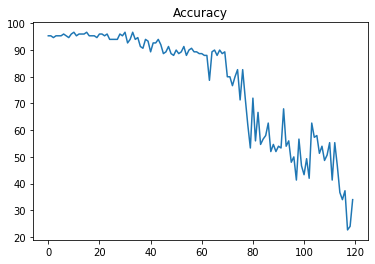

In [ ]:
performance = list()
for i in range (1,121):
    num_neighbors = i
    scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors, euclidean_distance)
    mean_score = (sum(scores)/float(len(scores)))
    #print('K: ', i,' Mean Accuracy: %.3f%%'  %mean_score)
    performance.append(mean_score)
    

from matplotlib import pyplot as plt

print('maximum accuracy: ', max(performance), '%% with K value: ', performance.index(max(performance))+1)


plt.title('Accuracy')
plt.plot(performance)

Because the range between features are similiar (feature 1 is ranged from 4.3 to 7.9, feature 2 is 2.2 to 4.0, feature 3 is 1.0 to 6.9 and feature 4 is 0.1 to 2.5), no feature is dominating the other feature. so, that's why the normalization doesn't make a big difference

## **b. Standardization**

In [ ]:
# Preprocess
def standardize(dataset):
    
    #find the mean/average value of each column/feature
    from math import sqrt
    means = [0 for i in range(len(dataset[0]))]
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        means[i] = sum(col_values) / float(len(dataset))
    
    #find the standard deviation value of each column/feature
    stdevs = [0 for i in range(len(dataset[0]))]
    for i in range(len(dataset[0])):
        variance = [pow(row[i]-means[i], 2) for row in dataset]
        stdevs[i] = sum(variance)
    stdevs = [sqrt(x/(float(len(dataset)-1))) for x in stdevs]
    
    #uptdate the value for each column, according to the standardization formula
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - means[i]) / stdevs[i]
    
    return dataset
    
dataset = load_csv(filename)

for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

print('Before standardization:\n\n',dataset[:10])

dataset = standardize(dataset)

print('After standardization:\n\n',dataset[:10])

Before standardization:

 [[5.1, 3.5, 1.4, 0.2, 2], [4.9, 3.0, 1.4, 0.2, 2], [4.7, 3.2, 1.3, 0.2, 2], [4.6, 3.1, 1.5, 0.2, 2], [5.0, 3.6, 1.4, 0.2, 2], [5.4, 3.9, 1.7, 0.4, 2], [4.6, 3.4, 1.4, 0.3, 2], [5.0, 3.4, 1.5, 0.2, 2], [4.4, 2.9, 1.4, 0.2, 2], [4.9, 3.1, 1.5, 0.1, 2]]
After standardization:

 [[-0.8976738791967672, 1.0286112808972334, -1.3367940202882518, -1.3085928194379581, 1.2206555615733703], [-1.1392004834649543, -0.12454037930146059, -1.3367940202882518, -1.3085928194379581, 1.2206555615733703], [-1.3807270877331426, 0.3367202847780174, -1.3934698549528186, -1.3085928194379581, 1.2206555615733703], [-1.5014903898672372, 0.1060899527382784, -1.2801181856236847, -1.3085928194379581, 1.2206555615733703], [-1.0184371813308608, 1.2592416129369723, -1.3367940202882518, -1.3085928194379581, 1.2206555615733703], [-0.5353839727944845, 1.9511326090561882, -1.166766516294551, -1.0465248315665379, 1.2206555615733703], [-1.5014903898672372, 0.7979809488574944, -1.3367940202882518, -1.

note that we should seperate the target value first before standardize the dataset, but in this case it's okay because we want to classify, not regression.

Next, let's perform KNN using the standard euclidean distance:

maximum accuracy:  96.00000000000001 %% with K value:  11


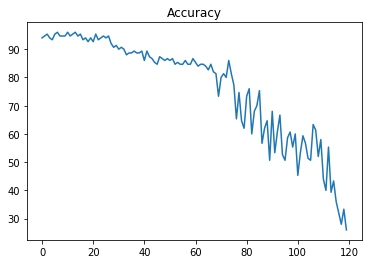

In [ ]:
performance = list()
for i in range (1,121):
    num_neighbors = i
    scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors, euclidean_distance)
    mean_score = (sum(scores)/float(len(scores)))
    #print('K: ', i,' Mean Accuracy: %.3f%%'  %mean_score)
    performance.append(mean_score)
    

from matplotlib import pyplot as plt

print('maximum accuracy: ', max(performance), '%% with K value: ', performance.index(max(performance))+1)


plt.title('Accuracy')
plt.plot(performance)

Just like the previous one, the standardization doesn't make a big difference because no feature is dominating others